# Approximation of the kernel matrix.

Author: <alberto.suarez@uam.es>

In this notebook we illustrate the quality of the approximation to the kernel matrix using random features of different types (RBF, Matérn) and Nystöm features.

Note that even the best results for classification need not be obtained by the method that gives the best approximation to the kernel matrix. The reason is that the approximation can have a regularization effect that may improve the accuracy of the predictions on the test set.

In [1]:
%load_ext autoreload
%autoreload 2

## Load necessary modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from sklearn import datasets
from sklearn.kernel_approximation import RBFSampler
from sklearn.gaussian_process.kernels import Matern
import kernel_approximation as ka


### RBF Kernel approximations

# of features =  10
# of features =  100
# of features =  1000
# of features =  10000


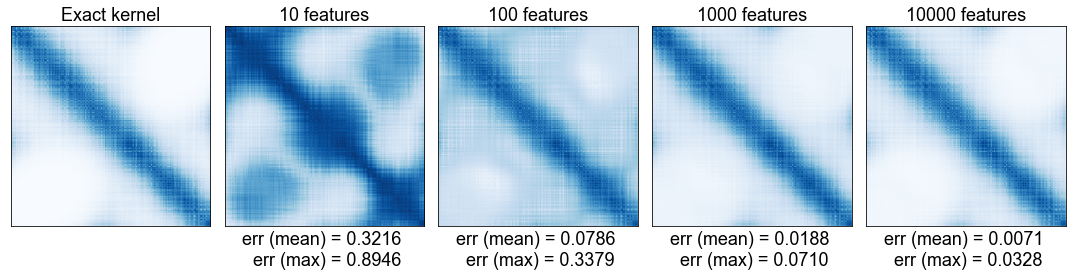

In [10]:
## Generate data
# 3-D data
n_instances = 1000
X, t = datasets.make_s_curve(n_instances, noise=0.1)
X = X[np.argsort(t)]

# Reshape if necessary
if (X.ndim == 1):
    X = X[:, np.newaxis]
    
# RBF kernel parameters 
sigma = 1.0
gamma = 1.0 / (2.0 * sigma**2)
rbf_sampler_kwargs = {'sigma': sigma}

# Kernel function
def kernel(X, Y):
    return rbf_kernel(X, Y, gamma=gamma) 

## Create an instance of the random features object
rbf_sampler = ka.RandomFeaturesSamplerRBF(sigma)

## Plot the approximation to the kernel matrix
n_random_features = [10, 100, 1000, 10000]

ka.demo_kernel_approximation_features(
    X, 
    kernel, 
    ka.RandomFeaturesSamplerRBF,
    rbf_sampler_kwargs,
    n_random_features
)

For the RBF kernel we see how the error converges to $0$ as the number of random features increases. In particular, using 1000 features yields a result visually equal to the exact kernel. This is quite impressive, considering we are using only 1000 out of the 1 million of availeable features.

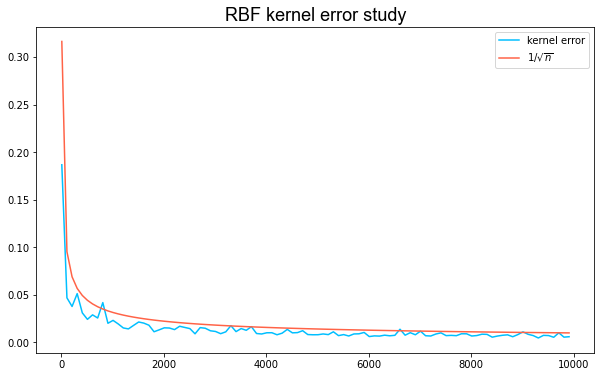

In [12]:
# Create the possible number of features and round them to ints
n_features =  np.arange(10, 10000, 100)

ka.plot_kernel_error(
    X, 
    kernel, 
    ka.RandomFeaturesSamplerRBF,
    rbf_sampler_kwargs,
    n_features,
    kernel_name='RBF'
)

plt.plot(n_features, 1.0/np.sqrt(n_features),
         color='tomato', label=r"$1/\sqrt{n}$")
plt.legend()
plt.show()

Upon plotting the error evolution against the number of random features used we find a mean error decline proportional to $1/\sqrt n$. This matches our theoretical intuition since the single source of randomess (and thus, of error) is the MonteCarlo technique, whose expected error rate is precisely proportional to $1/\sqrt n$. 

### Matern Kernel approximations

# of features =  10
# of features =  100
# of features =  1000
# of features =  10000


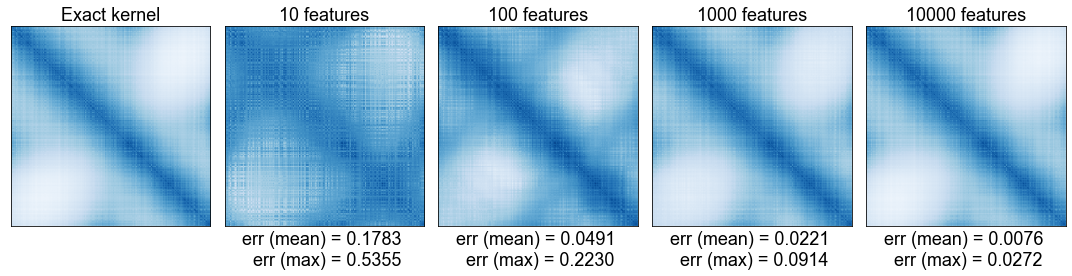

In [40]:
length_scale = 3.0
nu = 0.5

# 1 / scale due to compatibility changes with sklearn 
# 2 * nu due to compatibility changes with sklearn 
matern_sampler_kwargs = {'scale': 1.0/length_scale, 'nu': 2*nu}

kernel_matern = Matern(length_scale=length_scale, nu=nu) 

def kernel(X, Y):
    return kernel_matern(X, Y)

n_random_features = [10, 100, 1000, 10000]

ka.demo_kernel_approximation_features(
    X, 
    kernel, 
    ka.RandomFeaturesSamplerMatern,
    matern_sampler_kwargs,
    n_random_features
)

Although for a lower number of features the kernel seems worse than the respective RBF one, the numerical values show that it is, in fact, better. However, when the number of features increases the RBF kernel becomes slightly better.

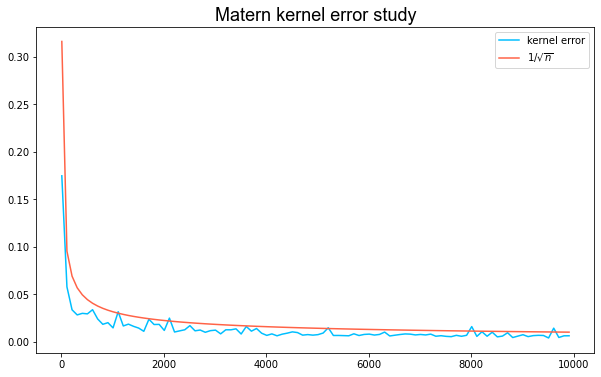

In [37]:
# Create the possible number of features and round them to ints
n_features =  np.arange(10, 10000, 100)

ka.plot_kernel_error(
    X, 
    kernel, 
    ka.RandomFeaturesSamplerMatern,
    matern_sampler_kwargs,
    n_features,
    kernel_name='Matern'
)

plt.plot(n_features, 1.0/np.sqrt(n_features),
         color='tomato', label=r"$1/\sqrt{n}$")
plt.legend()
plt.show()

Since the Matern kernel shares the same source of error than RBF, they also share their mean error trend over time, as we can see in the graph above.

### Nystroem Kernel approximations

# of features =  10
# of features =  100
# of features =  1000


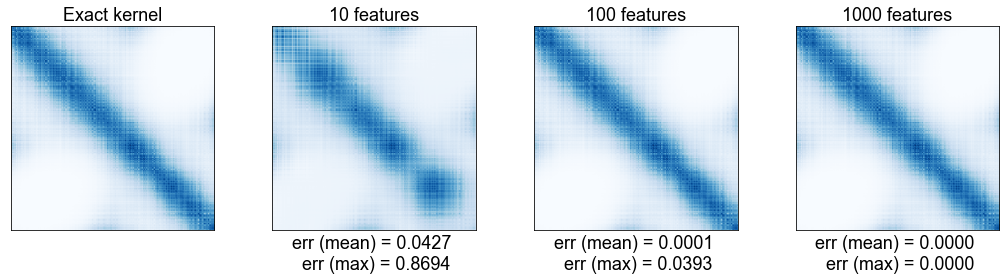

In [41]:
# Kernel parameters 
sigma = 1.0
gamma = 1.0 / (2.0 * sigma**2)

# Kernel matrix
def kernel(X, Y):
    return rbf_kernel(X, Y, gamma=gamma) 

nystroem_sampler_kwargs = {'kernel': kernel}
nystroem_sampler = ka.NystroemFeaturesSampler(kernel)

n_nystroem_features = [10, 100, 1000]

ka.demo_kernel_approximation_features(
    X, 
    kernel, 
    ka.NystroemFeaturesSampler,
    nystroem_sampler_kwargs,
    n_nystroem_features
)

For our last kernel we see an astonishingly faster convergence. Considering that the maximum number of features for this kernel is 1000, this result might be completely expected. However, with only 10 features we obtain an error equivalent to the ones obtained with the RBF and Matern kernels at a hundred random features and with 100 we are already better than any kernel reconstruction we have seen before.

We also need to point out that we have noticedhow  this method is computationally more requiring. However, we have not run any additional experiments to further test this hypothesis.

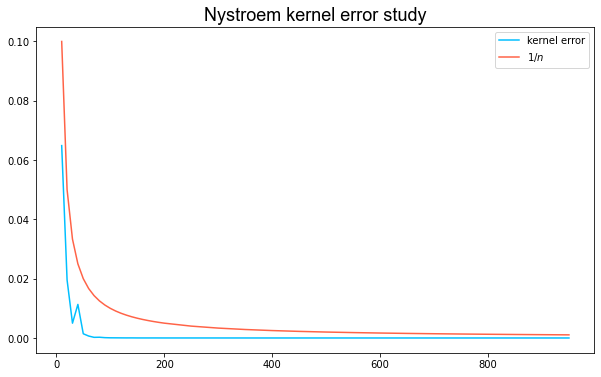

In [43]:
# Create the possible number of features and round them to ints
n_features = np.concatenate((
    np.arange(10, 200, 10),
    np.arange(200, 1000, 50)
))

ka.plot_kernel_error(
    X, 
    kernel, 
    ka.NystroemFeaturesSampler,
    nystroem_sampler_kwargs,
    n_features,
    kernel_name='Nystroem'
)

plt.plot(n_features, 1/n_features,
         color='tomato', label=r"$1/n$")
plt.legend()
plt.show()

Finally, the Nystroem method doesn't rely on MonteCarlo approximation, so the source of the error doesn't come from it. Instead, it must be related to the error of uniformly sampling a rnadom subset of elements, as computed with the columns.

Empirically we have found a decline proportional to $1/n$.